# Task 5 - Pretrained Model
5390<br>
Elaina Rohlfing

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.models import load_model

## Load the data
* Upload & unzip the dataset
* Load training and validation images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! rm -rf morel-dataset
! unzip -qq "/content/drive/MyDrive/Colab Notebooks/morel-dataset.zip"
! mv morel-dataset* morel-dataset

In [4]:
! ls -l morel-dataset/validation

total 8
drwxr-xr-x 2 root root 4096 May  3 04:57 morel
drwxr-xr-x 2 root root 4096 May  3 04:58 none


## Prepare the images (training and validation)

In [6]:
def get_raw_images(image_size=(256, 256), size_of_batch=32):
    img_generator = ImageDataGenerator()

    tr = img_generator.flow_from_directory( "./morel-dataset/train", target_size=image_size, shuffle=True, seed=999, class_mode='binary', classes=["none", "morel"], batch_size=size_of_batch)
    val = img_generator.flow_from_directory( "./morel-dataset/validation", target_size=image_size, shuffle=True, seed=999, class_mode='binary', classes=["none", "morel"], batch_size=size_of_batch)
    tst = img_generator.flow_from_directory( "./morel-dataset/test", target_size=image_size, shuffle=True, seed=999, class_mode='binary', classes=["none", "morel"], batch_size=size_of_batch)
    return tr, val, tst


# Review details of dataset
def print_data_characteristics(data):
    print(f'{data.class_indices=}')
    print(f'{data.num_classes=}')
    print(f'{data.batch_size=}')
    print(f'{data.samples=}')
    print(f'{data.image_shape=}')

    # check baseline accurracy (for majority class in binary classification)
    num_class0 = data.classes[data.classes == 0].size
    num_class1 = data.classes[data.classes == 1].size
    class1_relative_size = (100 * (num_class1/(num_class0 + num_class1)))
    class0_relative_size = (100 - class1_relative_size)
    if class1_relative_size > class0_relative_size:
        print(f'\nMajority class is class[1]\nBaseline accuracy for this dataset is: {class1_relative_size:.2f}%')
    else:
        print(f'\nMajority class is class[0]\nBaseline accuracy for this dataset is: {class0_relative_size:.2f}%')


# Displays one image and its label
def display_image(dataset, img_index=0, batch_index=0, raw=False):
    norm = 255 if raw else 1
    images, labels = dataset[batch_index]
    class_index = int(labels[img_index])
    classes = list(dataset.class_indices.keys())

    plt.imshow(images[img_index] / norm)
    plt.title(f"Ground truth: {str(labels[img_index])}\n{classes[class_index]}") # add name of label train_ds.class_indices
    plt.axis("off")

# Displays multiple random images in a grid
def review_generator_results(image_gen, batch_number=0, num_images=6, num_rows=2, raw=True):
    indices = np.random.choice(image_gen.batch_size, size=num_images, replace=False)
    plt.figure(figsize=(12, 8))
    for i, img_idx in enumerate(indices):
        plt.subplot(num_rows, (len(indices) + 1) // num_rows, i + 1)
        display_image(image_gen, img_idx, batch_number, raw)
    plt.tight_layout()
    plt.show()
    print_data_characteristics(image_gen)

In [7]:
train_set, val_set, test_set = get_raw_images(size_of_batch=64)

Found 552 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


Display one image and its label

TRAINING SET


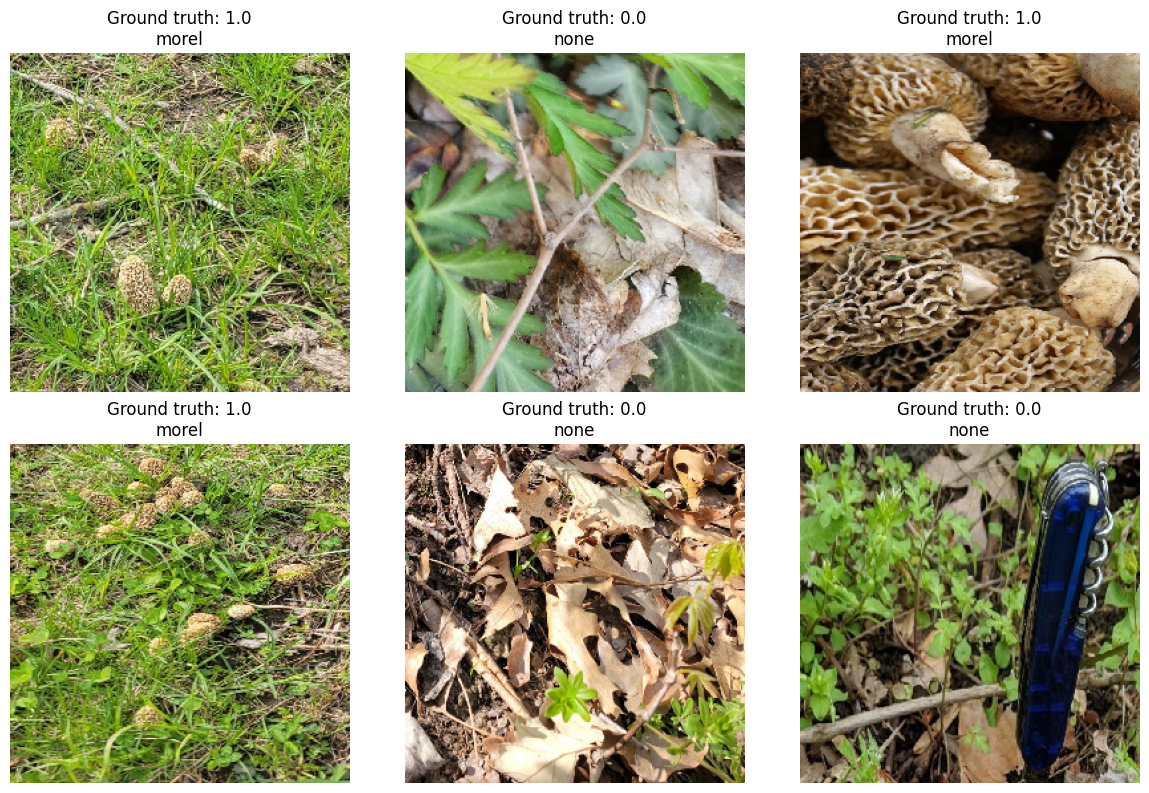

data.class_indices={'none': 0, 'morel': 1}
data.num_classes=2
data.batch_size=64
data.samples=552
data.image_shape=(256, 256, 3)

Majority class is class[0]
Baseline accuracy for this dataset is: 50.00%


In [8]:
print('TRAINING SET')
review_generator_results(train_set, num_images=6, num_rows=2, batch_number=0, raw=True)

VALIDATION SET


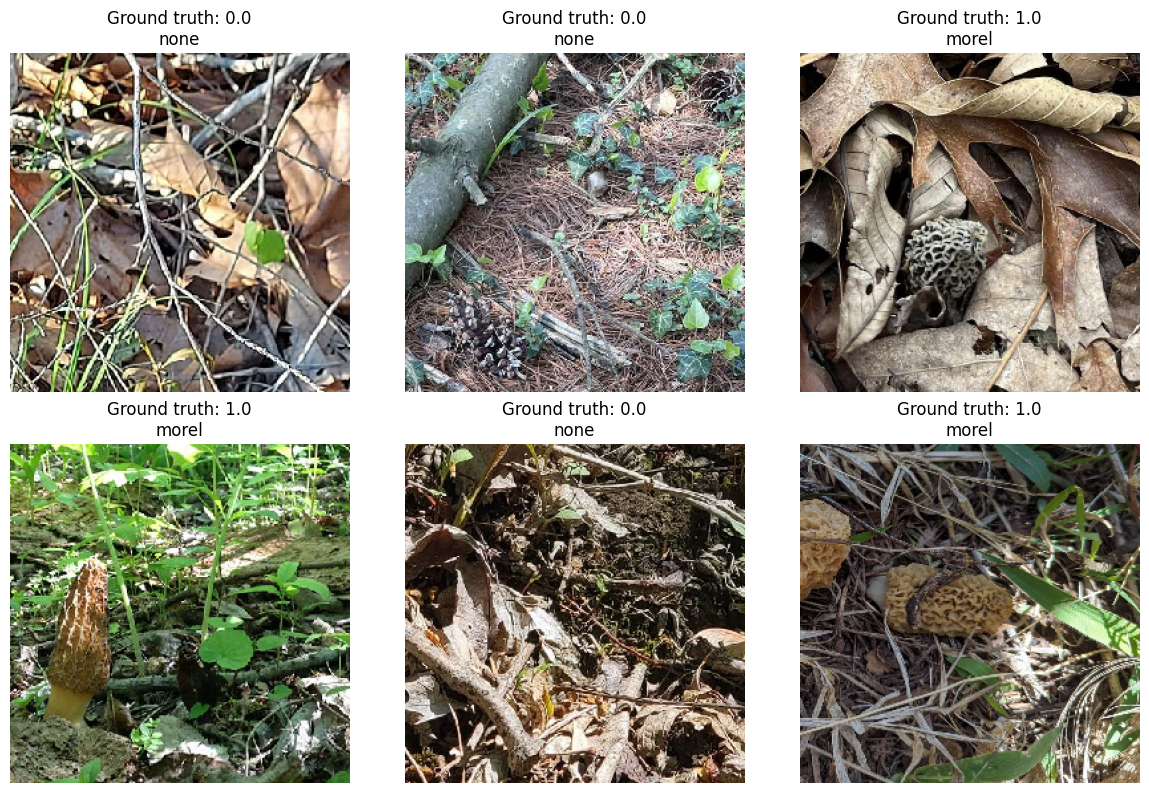

data.class_indices={'none': 0, 'morel': 1}
data.num_classes=2
data.batch_size=64
data.samples=160
data.image_shape=(256, 256, 3)

Majority class is class[0]
Baseline accuracy for this dataset is: 50.00%


In [9]:
print('VALIDATION SET')
review_generator_results(val_set, num_images=6, num_rows=2, batch_number=0)

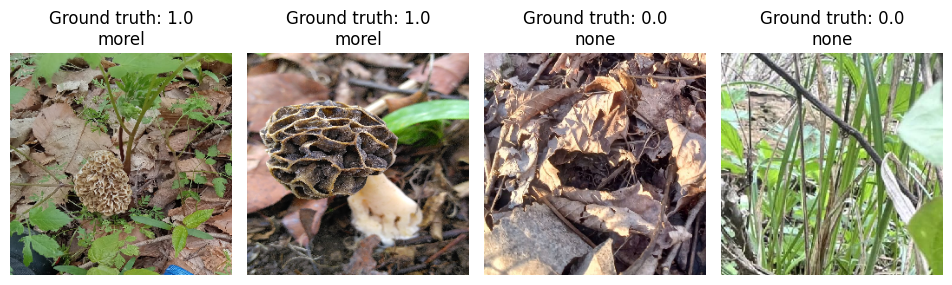

data.class_indices={'none': 0, 'morel': 1}
data.num_classes=2
data.batch_size=64
data.samples=80
data.image_shape=(256, 256, 3)

Majority class is class[0]
Baseline accuracy for this dataset is: 50.00%


In [11]:
review_generator_results(test_set, num_images=4, num_rows=1, raw=True)

# Functions

## Plot learning curves

In [17]:
def plot_learning_curves(hist, title, validate=False):
    fig, axs = plt.subplots(2, 1, figsize=(6, 7))
    epochs = range(1, len(hist.history['loss']) + 1)

    if validate:
        axs[0].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy', color="forestgreen")
    axs[0].plot(epochs, hist.history['accuracy'], label='Training Accuracy', color="limegreen")
    axs[0].set_title("Accuracy for " + title)
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylim([0, 1])
    axs[0].legend()

    if validate:
        axs[1].plot(epochs, hist.history['val_loss'], label='Validation Loss', color="forestgreen")
    axs[1].plot(epochs, hist.history['loss'], label='Training Loss', color="limegreen")
    axs[1].set_title("Loss for " + title)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.tight_layout()
    plt.show()


def plot_multiple_history(histories, history_labels, title):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))

    colors = list([color for color, rgb in mcolors.CSS4_COLORS.items() if mcolors.rgb_to_hsv(mcolors.to_rgba(rgb)[:3])[2] < 0.9])

    # Plot training and validation accuracy
    for i, h in enumerate(histories):
        axs[0].plot(h.history['accuracy'], label=f'Train Acc {history_labels[i]}', color=colors[i])
        axs[0].plot(h.history['val_accuracy'], label=f'Val Acc {history_labels[i]}', color=colors[i], marker='o', markersize=3, linestyle='')
    axs[0].set_title(f'Accuracy - Model {i+1}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim([0, 1])
    axs[0].legend()

    # Plot training and validation loss
    for i, h in enumerate(histories):
        axs[1].plot(h.history['loss'], label=f'Train Loss {history_labels[i]}', color=colors[i])
        axs[1].plot(h.history['val_loss'], label=f'Val Loss {history_labels[i]}', color=colors[i], marker='o', markersize=3, linestyle='')
    axs[1].set_title(f'Loss - Model {i+1}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.tight_layout()
    plt.show()

## View Predictions

In [18]:
# modified code from chatgpt
def plot_misclassified_images(model, data_generator, num_images_per_class=4):
    images, true_labels = data_generator.next()
    predictions = model.predict(images)
    predicted_labels = np.round(predictions).flatten().astype(int)  # Round predictions for binary classification

    misclassified_indices = np.where(predicted_labels != true_labels)[0][:10]
    misclassified_morel = np.where((predicted_labels == 1) & (predicted_labels != true_labels))[0][:]
    misclassified_none = np.where((predicted_labels == 0) & (predicted_labels != true_labels))[0][:]

    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(misclassified_none):
        image = images[idx]
        true_label = 'Morel' if true_labels[idx] == 1 else 'None'
        predicted_label = 'Morel' if predicted_labels[idx] == 1 else 'None'

        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nPredicted: {predictions[idx]}')
        plt.axis('off')
        if i == (num_images_per_class - 1): break
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12, 8))
    for j, idx in enumerate(misclassified_morel):
        image = images[idx]
        true_label = 'Morel' if true_labels[idx] == 1 else 'None'
        predicted_label = 'Morel' if predicted_labels[idx] == 1 else 'None'

        plt.subplot(1, num_images_per_class, j + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nPredicted: {predictions[idx]}')
        plt.axis('off')
        if j == (num_images_per_class - 1): break
    plt.tight_layout()
    plt.show()

In [19]:
# modified code from chatgpt
def plot_successful_predictions(model, data_generator, num_images_per_class=4):
    images, true_labels = data_generator.next()
    predictions = model.predict(images)
    predicted_labels = np.round(predictions).flatten().astype(int)  # Round predictions for binary classification

    classified_indices = np.where(predicted_labels == true_labels)[0][:]
    classified_morel = np.where((predicted_labels == 1) & (predicted_labels == true_labels))[0][:]
    classified_none = np.where((predicted_labels == 0) & (predicted_labels == true_labels))[0][:]

    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(classified_none):
        image = images[idx]  # Get the image from the generator
        true_label = 'Morel' if true_labels[idx] == 1 else 'None'
        predicted_label = 'Morel' if predicted_labels[idx] == 1 else 'None'

        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nPredicted: {predictions[idx]}')
        plt.axis('off')
        if i == (num_images_per_class - 1): break
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    for j, idx in enumerate(classified_morel):
        image = images[idx]  # Get the image from the generator
        true_label = 'Morel' if true_labels[idx] == 1 else 'None'
        predicted_label = 'Morel' if predicted_labels[idx] == 1 else 'None'

        plt.subplot(1, num_images_per_class, j + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nPredicted: {predictions[idx]}')
        plt.axis('off')
        if j == (num_images_per_class - 1): break
    plt.tight_layout()
    plt.show()

# Setup Pretrained Model


### When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model.

## Mobile Net - Train to Convergence
This model has potential applications as a mobile tool that could assist foragers on their hunt. For this reason, MobileNet was selected for training.

In [44]:
train_set.image_shape

(256, 256, 3)

In [12]:
# load base of the pretrained model
mobileNV2_base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=train_set.image_shape)

# freeze the layers to preseve weight values during initial training
mobileNV2_base.trainable=False
mobileNV2_base.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

Setting up an augmentation layer so that the finished model is capeable of augmenting raw data. To make sure augmentation values are reasonable augmentation is repeatedly applied to a single image and the results are plotted below.

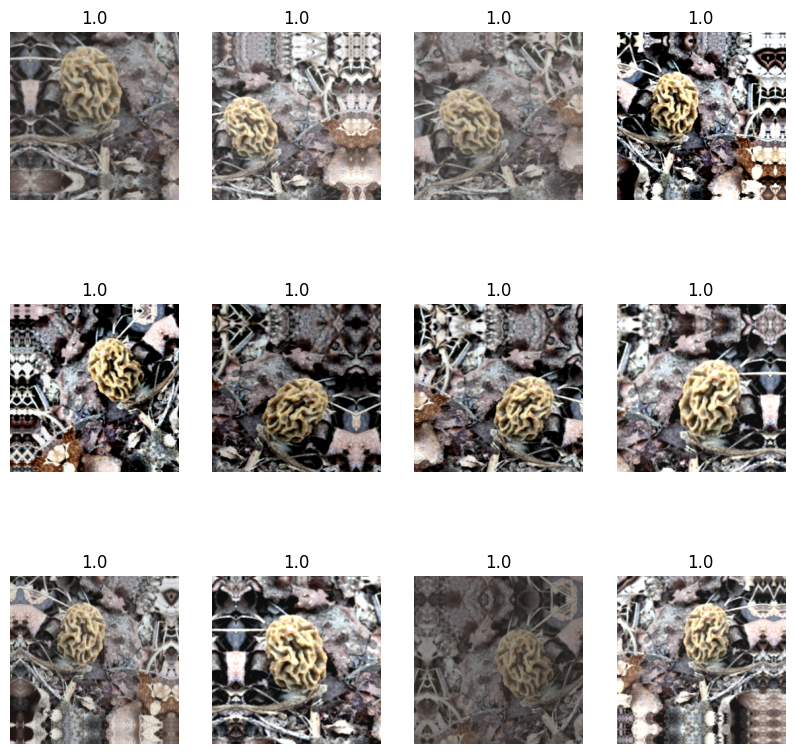

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.15),
        layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
        layers.RandomContrast(factor=0.65),
        layers.RandomBrightness(factor=.15)
    ]
)

# preview augmented images
imgs, lab = train_set.next()
plt.figure(figsize=(10, 10))
for i in range(12):
    augmented_image = data_augmentation(imgs[1], training=True)
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_image / 255)
    plt.title(lab[1])
    plt.axis("off")
plt.show()

* first was **Following the guide at** https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing

In [14]:
from tensorflow.keras.optimizers import Adam
print(f'Input images are size {train_set.image_shape}')
inputs = keras.Input(shape=train_set.image_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = mobileNV2_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # activation not necessary for raw prediction value
x = layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="mobilenet-augmentation")
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])
model.summary()

Input images are size (256, 256, 3)
Model: "mobilenet-augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
        

In [15]:
num_epochs = 50
batch = 32

# image callbacks
# set filepath for checkpointing
model_filename = f"{model.name}-feature-extract0505.hg5"
cb_checkpoint = callbacks.ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor="val_loss")

print("Fitting the top layer of the model")
history = model.fit(train_set, epochs=num_epochs, validation_data=val_set, callbacks=cb_checkpoint, batch_size=batch)

Fitting the top layer of the model
Epoch 1/50
9/9 [==============================] - 17s 814ms/step - loss: 0.7274 - accuracy: 0.5344 - val_loss: 0.6282 - val_accuracy: 0.6812
Epoch 2/50
9/9 [==============================] - 11s 1s/step - loss: 0.6435 - accuracy: 0.6341 - val_loss: 0.5422 - val_accuracy: 0.8000
Epoch 3/50
9/9 [==============================] - 5s 565ms/step - loss: 0.5661 - accuracy: 0.7246 - val_loss: 0.4755 - val_accuracy: 0.8375
Epoch 4/50
9/9 [==============================] - 8s 956ms/step - loss: 0.5366 - accuracy: 0.7283 - val_loss: 0.4270 - val_accuracy: 0.8500
Epoch 5/50
9/9 [==============================] - 6s 718ms/step - loss: 0.4829 - accuracy: 0.7808 - val_loss: 0.3877 - val_accuracy: 0.8625
Epoch 6/50
9/9 [==============================] - 6s 648ms/step - loss: 0.4520 - accuracy: 0.8188 - val_loss: 0.3601 - val_accuracy: 0.8750
Epoch 7/50
9/9 [==============================] - 5s 546ms/step - loss: 0.4405 - accuracy: 0.8116 - val_loss: 0.3379 - val_acc

In [22]:
# set filepath for checkpointing
model_filename = f"e{model.name}-feature-extract0505.hg5"
cb_checkpoint = callbacks.ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor="val_loss")
history = model.fit(train_set, epochs=2, validation_data=val_set, callbacks=cb_checkpoint, batch_size=batch)

Epoch 1/2
9/9 [==============================] - 23s 3s/step - loss: 0.2541 - accuracy: 0.9022 - val_loss: 0.1658 - val_accuracy: 0.9312
Epoch 2/2
9/9 [==============================] - 23s 3s/step - loss: 0.2345 - accuracy: 0.9149 - val_loss: 0.1640 - val_accuracy: 0.9312


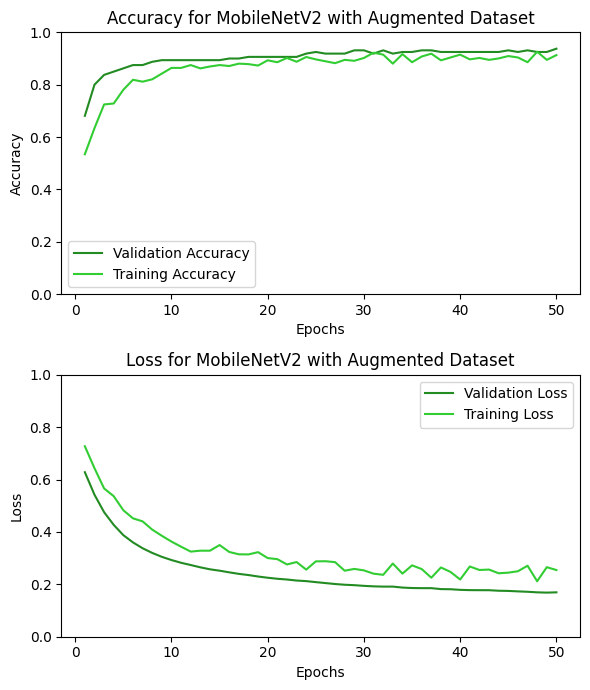

In [20]:
plot_learning_curves(history, "MobileNetV2 with Augmented Dataset", validate=True)

In [2]:
from tensorflow.keras.models import load_model
model_path = "/content/drive/MyDrive/Colab Notebooks/tmp-models/emobilenet-augmentation-feature-extract0505.hg5"
model = load_model(model_path)
model.summary()

OSError: No file or directory found at /content/drive/MyDrive/Colab Notebooks/tmp-models/emobilenet-augmentation-feature-extract0505.hg5

Review the predictions the model is making at this stage

In [42]:
images.shape

(64, 256, 256, 3)

In [43]:
# https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing
images, labels = val_set.next()
processed_img = preprocess_input(images)
print(f'{processed_img.shape=}')
predictions = model.predict(processed_img)

#predictions = tf.nn.sigmoid(predictions)
#predictions = tf.where(predictions < 0.5, 0, 1)

processed_img.shape=(64, 256, 256, 3)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'mobilenet-augmentation' (type Functional).
    
    Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 256, 3), found shape=(32, 256, 256, 3)
    
    Call arguments received by layer 'mobilenet-augmentation' (type Functional):
      • inputs=tf.Tensor(shape=(32, 256, 256, 3), dtype=float32)
      • training=False
      • mask=None


In [ ]:
print(f'{type(predictions)=}')
print('Predictions:\n', predictions.numpy().flatten())
print('Labels:\n', labels)

Predictions:
 [0.726604   0.730456   0.503274   0.5182125  0.5528472  0.5120731
 0.5024033  0.59439826 0.7288505  0.6578639  0.50735104 0.5179222
 0.5052263  0.50390834 0.5474719  0.729633   0.73096293 0.65119016
 0.55306536 0.7304453  0.72639203 0.53351593 0.50108206 0.68847704
 0.7146979  0.5234249  0.5544234  0.72661513 0.71195984 0.72938114
 0.5118172  0.65895164 0.7304036  0.50650144 0.7278951  0.7295447
 0.5085985  0.55761886 0.5583059  0.6995057  0.7309216  0.60823846
 0.57730794 0.72807354 0.7299178  0.7303189  0.5082143  0.7309656
 0.5504208  0.7260769  0.7070869  0.5218214  0.72612256 0.5094069
 0.50865513 0.6086675  0.71829784 0.58879757 0.5454438  0.55276716
 0.5170081  0.7288914  0.6141822  0.521682  ]
Labels:
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0.]


## Fine tuning MobileNetV2

**Decide how many layers you'd like to retrain (closer to classifer is better because those layers are more specialized to the data, futher should be general representations that will help you)**

In [ ]:
# https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing
mobileNV2_base.trainable = True
print(  "Number of layers in the base model: ", len(base.layers))

fine_tune_at = 90

# freeze every lower layer
for layer in mobileNV2_base.layers[:fine_tune_at]:
    layer.trainable = False

# recompile and lower the learning rate
model.compile(loss="binary_crossentropy", optimizer=RMSprop(learning_rate=0.00001), metrics=[BinaryAccuracy(threshold=0.5, name='accuracy')])
model.summary()

Number of layers in the base model:  154
Model: "mobilenet-augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
   

In [ ]:
len(model.trainable_variables)

68

In [ ]:
history_tuning = model.fit(train_set, epochs=40, initial_epoch=len(history.epoch), validation_data=val_set, batch_size=batch)


Epoch 21/40
9/9 [==============================] - 14s 587ms/step - loss: 0.2832 - accuracy: 0.8786 - val_loss: 0.1477 - val_accuracy: 0.9438
Epoch 22/40
9/9 [==============================] - 4s 467ms/step - loss: 0.1920 - accuracy: 0.9330 - val_loss: 0.1325 - val_accuracy: 0.9500
Epoch 23/40
9/9 [==============================] - 4s 472ms/step - loss: 0.1852 - accuracy: 0.9293 - val_loss: 0.1152 - val_accuracy: 0.9500
Epoch 24/40
9/9 [==============================] - 4s 495ms/step - loss: 0.2269 - accuracy: 0.9221 - val_loss: 0.1153 - val_accuracy: 0.9625
Epoch 25/40
9/9 [==============================] - 4s 475ms/step - loss: 0.1856 - accuracy: 0.9293 - val_loss: 0.0987 - val_accuracy: 0.9688
Epoch 26/40
9/9 [==============================] - 4s 477ms/step - loss: 0.1681 - accuracy: 0.9348 - val_loss: 0.1026 - val_accuracy: 0.9688
Epoch 27/40
9/9 [==============================] - 4s 483ms/step - loss: 0.1840 - accuracy: 0.9330 - val_loss: 0.1119 - val_accuracy: 0.9625
Epoch 28/40


In [ ]:
history_tuning1 = model.fit(train_set, epochs=60, initial_epoch=len(history_tuning.epoch), validation_data=val_set, batch_size=batch)

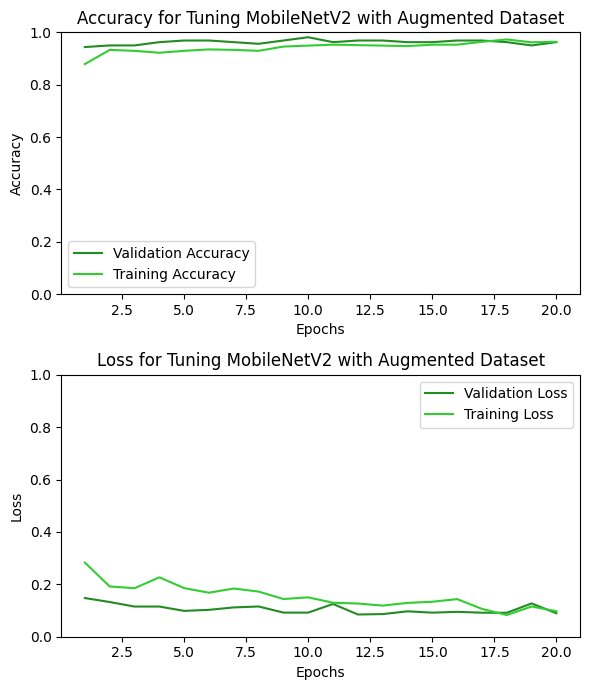

In [ ]:
plot_learning_curves(history_tuning, "Tuning MobileNetV2 with Augmented Dataset", validate=True)

## Make Predictions

1/1 [==============================] - 0s 30ms/step
Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0.]


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

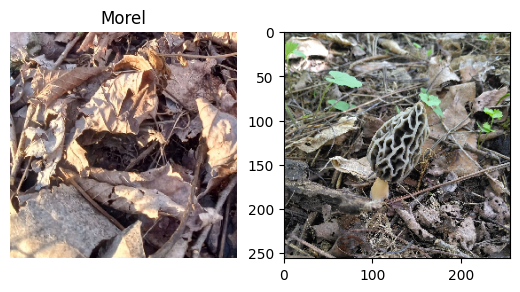

In [ ]:
# https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing
images, labels = test_set.next()
predictions = model.predict(images)

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy().flatten())
print('Labels:\n', labels)

class_names = ["None", "Morel"]
plt.figure(figsize=(10, 10))
for i, pred in enumerate(predictions):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[pred[i]])
    plt.axis("off")
